In [1]:
from pathlib import Path

In [28]:
from collections import defaultdict

def read_logfile(path):
    path = Path(path)

    psnr = {"test":defaultdict(list),"train":defaultdict(list)}
    l1 = {"test":defaultdict(list),"train":defaultdict(list)}
    curr_name = ""
    for line in path.read_text().split("\n"):
        if "Optimizing" in line:
            # print(line)
            curr_name = line.split(" ")[-1]
            if curr_name in psnr["test"]:
                if curr_name=="output/table_images3_depth0_rand":
                    curr_name = "output/table_images3_depth0_depth"
                if curr_name=="output/table_images3_depth0.8_rand":
                    curr_name = "output/table_images3_depth0.8_depth"
                if curr_name=="output/table_images3_depth0.3_rand":
                    curr_name = "output/table_images3_depth0.3_depth"
                if curr_name=="output/table_images3_depth0_minvis2":
                    break
                if curr_name=="output/table_images3_depth0.3_minvis2":
                    break
        if "Evaluating" in line:
            # print(line)
            split = line.split(":")[0].split(" ")[-1]
            curr_l1 = line.split(":")[1].split(" ")[2]
            curr_psnr = line.split(":")[1].split(" ")[4]
            
            psnr[split][curr_name].append(float(curr_psnr))
            l1[split][curr_name].append(float(curr_l1))
    return psnr,l1

In [62]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plotLogfile(path):

    psnr,l1 = read_logfile(path)

    split = "test"
    metric = psnr
    colorind = defaultdict(int)
    for i,name in enumerate(metric[split]):
        depth = name.split("depth")[1].split("_")[0]
        style = {"0":"--","0.8":"-","0.3":"o-",}[depth]
        plt.plot(metric[split][name],style,color=colors[colorind[depth]],label=name)
        colorind[depth] += 1
        

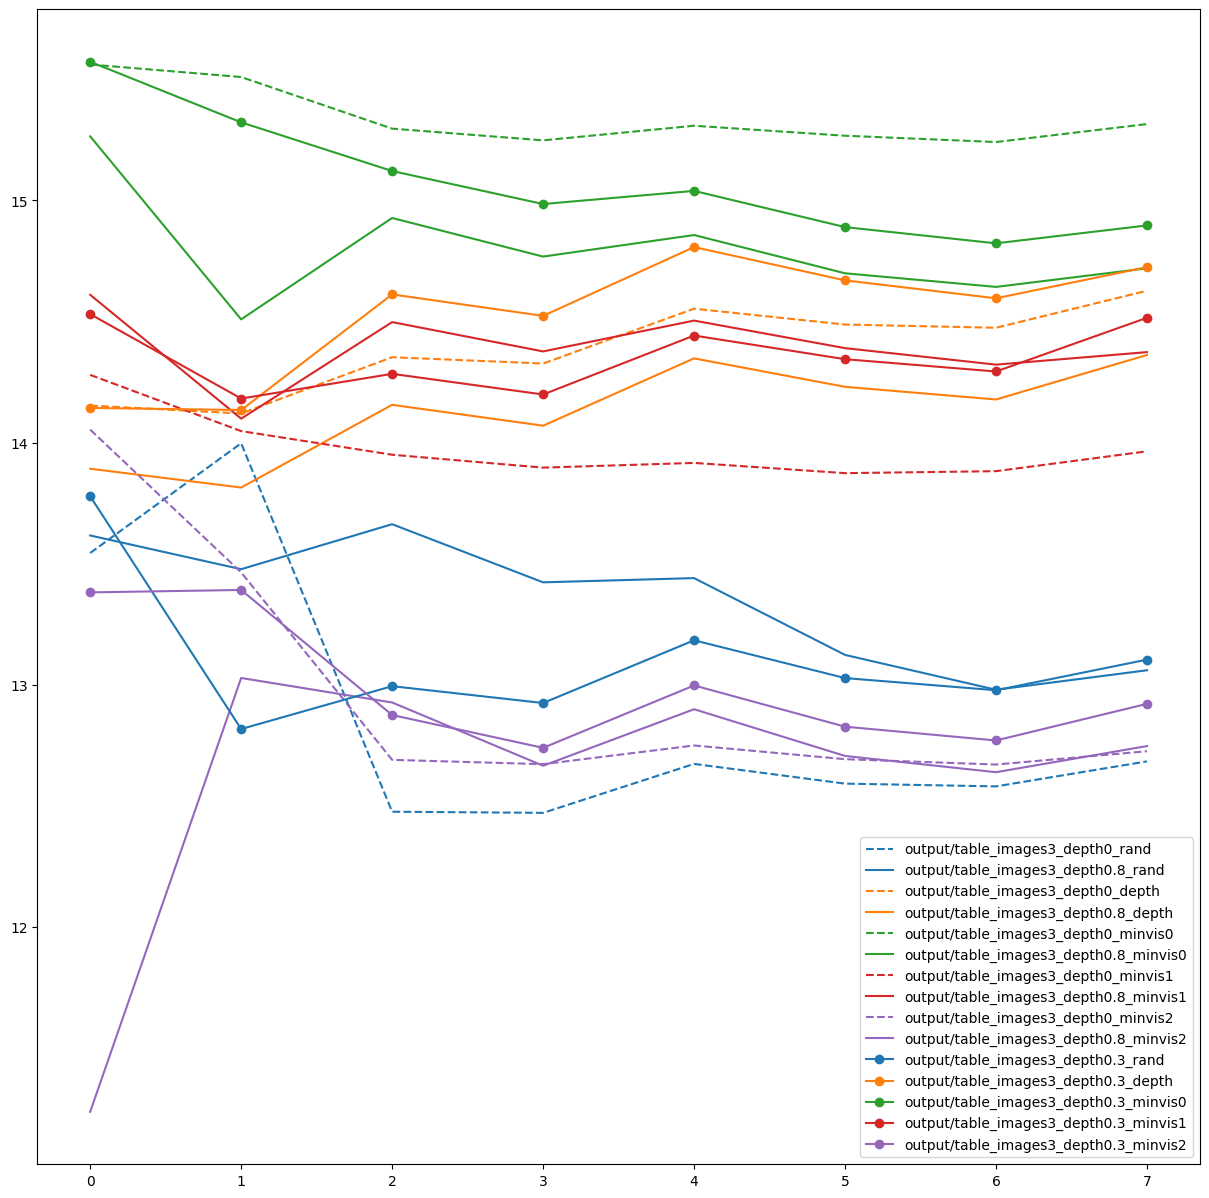

In [63]:

plt.figure(figsize=(15,15))
plotLogfile("train_logs/initialisations2")
plotLogfile("train_logs/initialisations3")

plt.legend()
plt.show()